In [16]:
import torch

In [ ]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [ ]:
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt, numpy as np, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os, time, copy, pandas as pd
from glob import glob

In [7]:
data_dir = "/content/drive/MyDrive/deep/Cat-Dog_Pandas"  # adjust if needed
train_dir = os.path.join(data_dir, "Train")
test_dir  = os.path.join(data_dir, "Test")
val_dir = os.path.join(data_dir, "Valid")

In [8]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=test_tfms)


In [10]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)


In [11]:
class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['cat', 'dog', 'panda']


In [12]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


In [13]:
import torch
import torch.nn as nn
from torchvision import models

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# ✅ Freeze existing layers
for param in model.parameters():
    param.requires_grad = False

# ✅ Replace final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))  # your number of classes
)

# ✅ Move to device
model = model.to(device)

print(model)


Using device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob
import os

# ✅ Paths
train_dir = "/content/drive/MyDrive/deep/Cat-Dog_Pandas/Train"
val_dir = "/content/drive/MyDrive/deep/Cat-Dog_Pandas/Valid"
test_dir = "/content/drive/MyDrive/deep/Cat-Dog_Pandas/Test"

# ✅ Transforms
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Normal datasets
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=test_tfms)
class_names = train_ds.classes
print("Classes:", class_names)

# ✅ Custom dataset for test (no subfolders)
class CustomTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.files = []
        for ext in ('*.jpg', '*.jpeg', '*.png'):
            self.files.extend(glob.glob(os.path.join(test_dir, ext)))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_path  # return path to identify later

test_ds = CustomTestDataset(test_dir, transform=test_tfms)

# ✅ Dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"✅ Loaded {len(train_ds)} train, {len(val_ds)} valid, {len(test_ds)} test images.")


Classes: ['cat', 'dog', 'panda']
✅ Loaded 2100 train, 300 valid, 600 test images.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# ✅ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# ✅ Load pre-trained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze conv layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))
)
model = model.to(device)

# ✅ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# ✅ Training loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects.double() / len(train_loader.dataset)

    # ✅ Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # ✅ Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_resnet18.pth")

print("✅ Training complete. Best val acc:", best_val_acc)


Training on: cuda


Epoch [1/10] - Train Loss: 0.2871, Acc: 0.8971 | Val Loss: 0.1955, Acc: 0.9167


Epoch [2/10] - Train Loss: 0.1466, Acc: 0.9448 | Val Loss: 0.1041, Acc: 0.9600


Epoch [3/10] - Train Loss: 0.1162, Acc: 0.9581 | Val Loss: 0.0833, Acc: 0.9567


Epoch [4/10] - Train Loss: 0.1278, Acc: 0.9524 | Val Loss: 0.0930, Acc: 0.9600


Epoch [5/10] - Train Loss: 0.1107, Acc: 0.9619 | Val Loss: 0.1041, Acc: 0.9633


Epoch [6/10] - Train Loss: 0.1192, Acc: 0.9538 | Val Loss: 0.1594, Acc: 0.9367


Epoch [7/10] - Train Loss: 0.1071, Acc: 0.9557 | Val Loss: 0.0866, Acc: 0.9667


Epoch [8/10] - Train Loss: 0.0959, Acc: 0.9605 | Val Loss: 0.0923, Acc: 0.9567


Epoch [9/10] - Train Loss: 0.0984, Acc: 0.9624 | Val Loss: 0.1030, Acc: 0.9600


Epoch [10/10] - Train Loss: 0.0911, Acc: 0.9648 | Val Loss: 0.0976, Acc: 0.9567
✅ Training complete. Best val acc: tensor(0.9667, device='cuda:0', dtype=torch.float64)


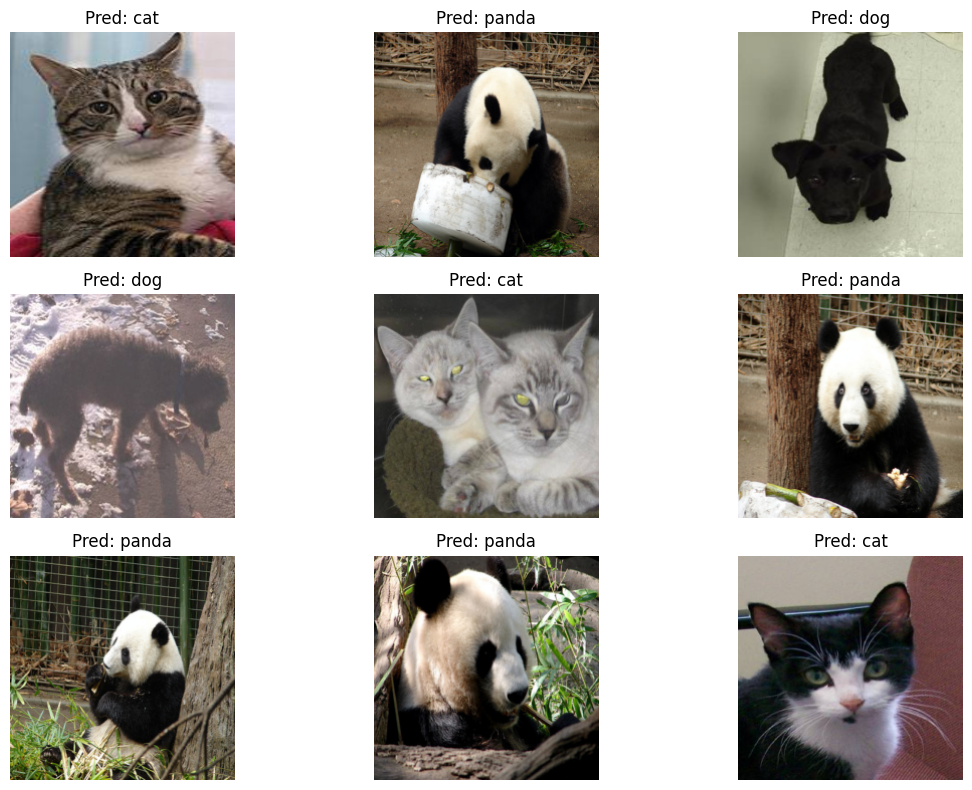

Name: Tamizhselvan B
Reg.no: 212223230225


In [19]:
import matplotlib.pyplot as plt
import random

# Load best model
model.load_state_dict(torch.load("best_model_resnet18.pth"))
model.eval()

def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Show random test predictions
fig = plt.figure(figsize=(12, 8))
rows, cols = 3, 3
for i in range(9):
    idx = random.randint(0, len(test_ds)-1)
    img, path = test_ds[idx]
    inputs = img.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    label = class_names[preds]
    ax = plt.subplot(rows, cols, i+1)
    imshow(img, title=f"Pred: {label}")
plt.tight_layout()
plt.show()



print("Name: Tamizhselvan B")
print("Reg.no: 212223230225")